#### Análisis y Procesamiento de Señales

# Tarea Semanal N°5
## *Estimación espectral: Ancho de banda de señales reales*

#### Augusto Colugnatti - Mateo Murgia

## Introducción teórica








## Desarrollo
### *Definiciones y preparación del entorno*

In [16]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from numpy.fft import fft
import scipy.signal.windows as window
import scipy.stats as st
# import sounddevice as sd
import scipy.io as sio


# ------------------------------------------- Blackman-Tukey ------------------------------------------- #


def blackman_tukey (x, M):
    
    N = len(x)
    x_shape = x.shape
    
    if M == None:
        M = N//5
    
    len_r = (2*M)-1
    xx = x.ravel()[:len_r]
    
    r_xx = np.correlate (xx, xx, mode='same') / len_r
    
    per_BT = np.abs (fft(r_xx * window.hann(len_r), n=N))
    per_BT = per_BT.reshape(x_shape)
    
    return per_BT

### *Trabajando con ECG*

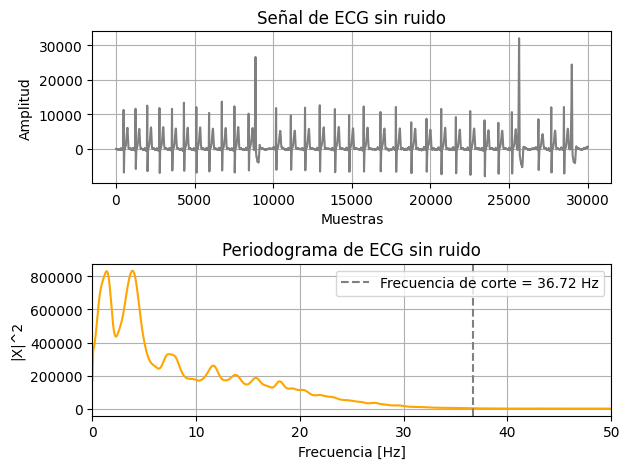

In [17]:
# ------------------------------------------- Lecutra de ECG ------------------------------------------- #


fs_ECG = 1000

# ECG = sio.whosmat ('./ECG_TP4.mat') # devuelve una lista de variables dentro del archivo .mat (MATLAB)
mat_struct = sio.loadmat ('./ECG_TP4.mat')
# print("Variables encontradas en el archivo .mat:", mat_struct.keys()) # esto muestra las variables dentro del archivo .mat (lo miro desde el explorador de variables)

ecg_one_lead = mat_struct ['ecg_lead'] # ECG con ruido

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']


# plt.figure (1)

# plt.subplot (3, 1, 1)
# plt.plot(ecg_one_lead[5000:12000])
# plt.grid (True)
# plt.subplot (3, 1, 2)
# plt.plot(hb_1)
# plt.grid (True)
# plt.subplot (3, 1, 3)
# plt.plot(hb_2)
# plt.grid (True)

# plt.tight_layout()
# plt.show()


# ------------------------------------------- ECG sin ruido ------------------------------------------- #


ECG_sr = np.load ('ecg_sin_ruido.npy') # toma el array que se encuentra en el archivo

N_ECG_sr = len (ECG_sr)

df_ECG_sr = fs_ECG / N_ECG_sr
nn_ECG_sr = np.arange (N_ECG_sr)

promedios_ECG_sr = 12 # parámetro inversamente proporcional a la varianza 
                    # en promedios = 1 tengo algo muy similar a la FFT pelada
                    # se debe ajustar la cantidad de promedios según: 1) mucha varianza, me quedé corto. 2) se corre el centro de masa del espectro, me fui al pasto
nperseg_ECG_sr = N_ECG_sr // promedios_ECG_sr
ff_ECG_sr, per_ECG_sr = sp.welch (ECG_sr, nfft = 5*nperseg_ECG_sr, fs = fs_ECG, nperseg = nperseg_ECG_sr, window = 'flattop') # N/nperseg es la cantidad de promedios que quiero hacer
# normalmente quiero tener un padding de al menos 1000 muestras (tomar con pinzas), en este caso depende de nperseg, ajusto con el parámetro nfft

energia_acum_sr = np.cumsum (per_ECG_sr) # esto devuelve un vector de sumas acumuladas, el area que estoy buscando vendría a ser el último valor
energia_acum_sr_norm = energia_acum_sr / energia_acum_sr[-1] # con [-1] accedo al último valor del vector
corte_ECG_sr = energia_acum_sr_norm[-1] * 0.995
indice_corte_sr = int (np.where (energia_acum_sr_norm >= corte_ECG_sr)[0][0]) # con [0][0] me devuelve el primer valor que cumple con la condición
frec_corte_sr = ff_ECG_sr[indice_corte_sr]


plt.figure (2)

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_sr, ECG_sr, color='gray')
plt.title ("Señal de ECG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_sr, per_ECG_sr, color='orange')
# plt.plot (ff_ECG_sr, 10*np.log10(np.abs(per_ECG_sr))) # representación en dB
plt.axvline (frec_corte_sr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_sr:.2f} Hz')
plt.title ("Periodograma de ECG sin ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 50)

plt.tight_layout()
plt.show()

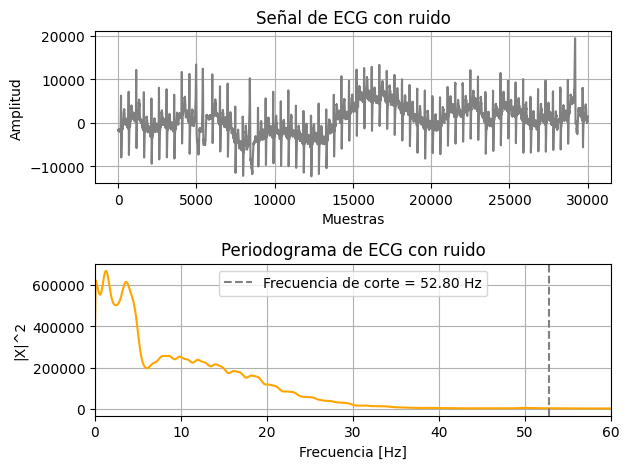

In [18]:
# ------------------------------------------- ECG con ruido ------------------------------------------- #


ECG_cr = ecg_one_lead[670000:700000].ravel()

N_ECG_cr = len (ECG_cr)

df_ECG_cr = fs_ECG / N_ECG_cr
nn_ECG_cr = np.arange (N_ECG_cr)

promedios_ECG_cr = 16
nperseg_ECG_cr = N_ECG_cr // promedios_ECG_cr

ff_ECG_cr, per_ECG_cr = sp.welch (ECG_cr, nfft = 5*nperseg_ECG_cr, fs = fs_ECG, nperseg = nperseg_ECG_cr, window = 'flattop')

energia_acum_cr = np.cumsum (per_ECG_cr)
energia_acum_cr_norm = energia_acum_cr / energia_acum_cr[-1]
corte_ECG_cr = energia_acum_cr_norm[-1] * 0.995
indice_corte_cr = int (np.where (energia_acum_cr_norm >= corte_ECG_cr)[0][0])
frec_corte_cr = ff_ECG_cr[indice_corte_cr]


plt.figure (3)

plt.subplot (2, 1, 1)
plt.plot (nn_ECG_cr, ECG_cr, color='gray')
# plt.plot (ff_ECG_cr, 10*np.log10(np.abs(per_ECG_cr))) # representación en dB
plt.title ("Señal de ECG con ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_ECG_cr, per_ECG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_cr:.2f} Hz')
plt.title ("Periodograma de ECG con ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

### *Trabajando con PPG*

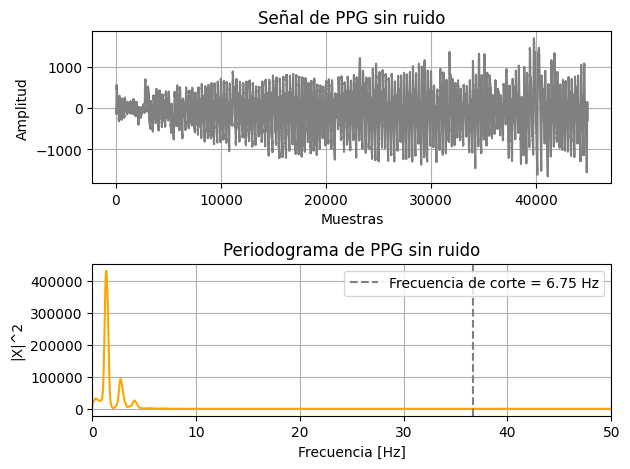

In [19]:
fs_PPG = 400

PPG_sr = np.load('ppg_sin_ruido.npy')

N_PPG_sr = len (PPG_sr)

df_PPG_sr = fs_PPG / N_PPG_sr
nn_PPG_sr = np.arange (N_PPG_sr)

promedios_PPG_sr = 12
nperseg_PPG_sr = N_PPG_sr // promedios_PPG_sr

ff_PPG_sr, per_PPG_sr = sp.welch (PPG_sr, nfft = 5*nperseg_PPG_sr, fs = fs_PPG, nperseg = nperseg_PPG_sr, window = 'flattop')

energia_acum_PPG_sr = np.cumsum (per_PPG_sr)
energia_acum_PPG_sr_norm = energia_acum_PPG_sr / energia_acum_PPG_sr[-1]
corte_PPG_sr = energia_acum_PPG_sr_norm[-1] * 0.995
indice_corte_PPG_sr = int (np.where (energia_acum_PPG_sr_norm >= corte_PPG_sr)[0][0])
frec_corte_PPG_sr = ff_PPG_sr[indice_corte_PPG_sr]

plt.figure (4)

plt.subplot (2, 1, 1)
plt.plot (nn_PPG_sr, PPG_sr, color='gray')
plt.title ("Señal de PPG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_PPG_sr, per_PPG_sr, color='orange')
plt.axvline (frec_corte_sr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_PPG_sr:.2f} Hz')
plt.title ("Periodograma de PPG sin ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 50)

plt.tight_layout()
plt.show()

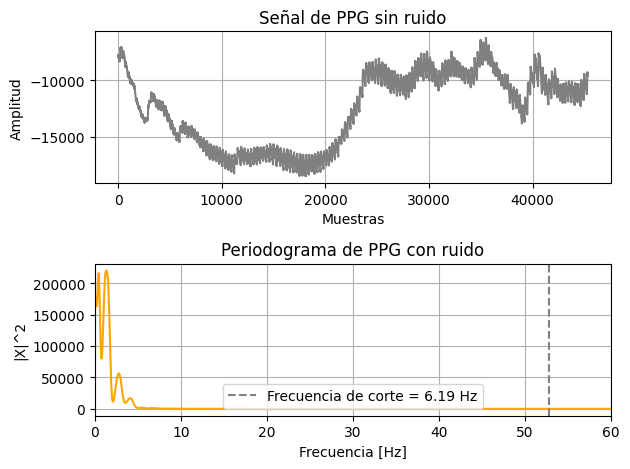

In [20]:
# ------------------------------------------- PPG con ruido ------------------------------------------- #


PPG_cr = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1) # omite la cabecera, si existe

N_PPG_cr = len (PPG_cr)

df_PPG_cr = fs_PPG / N_PPG_cr
nn_PPG_cr = np.arange (N_PPG_cr)

promedios_PPG_cr = 24
nperseg_PPG_cr = N_PPG_cr // promedios_PPG_cr

ff_PPG_cr, per_PPG_cr = sp.welch (PPG_cr, nfft = 5*nperseg_PPG_cr, fs = fs_PPG, nperseg = nperseg_PPG_cr, window = 'flattop')

energia_acum_PPG_cr = np.cumsum (per_PPG_cr)
energia_acum_PPG_cr_norm = energia_acum_PPG_cr / energia_acum_PPG_cr[-1]
corte_PPG_cr = energia_acum_PPG_cr_norm[-1] * 0.995
indice_corte_PPG_cr = int (np.where (energia_acum_PPG_cr_norm >= corte_PPG_cr)[0][0])
frec_corte_PPG_cr = ff_PPG_cr[indice_corte_PPG_cr]

plt.figure (5)

plt.subplot (2, 1, 1)
plt.plot (nn_PPG_cr, PPG_cr, color='gray')
plt.title ("Señal de PPG sin ruido")
plt.ylabel ("Amplitud")
plt.xlabel ("Muestras")
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_PPG_cr, per_PPG_cr, color='orange')
plt.axvline (frec_corte_cr, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_PPG_cr:.2f} Hz')
plt.title ("Periodograma de PPG con ruido")
plt.ylabel ("|X|^2")
plt.xlabel ("Frecuencia [Hz]")
plt.grid (True)
plt.legend ()
plt.xlim (0, 60)

plt.tight_layout()
plt.show()

### *Trabajando con audios*

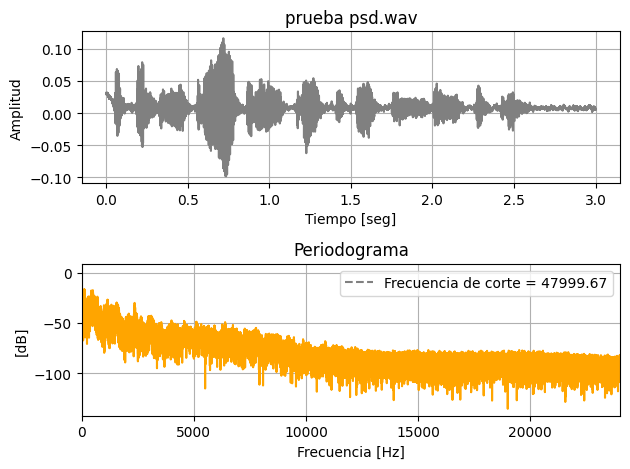

In [21]:
# ------------------------------------------- Lectura de audios ------------------------------------------- #


fs_1, wav_data_1 = sio.wavfile.read ('prueba psd.wav')
fs_2, wav_data_2 = sio.wavfile.read ('silbido.wav')
fs_3, wav_data_3 = sio.wavfile.read ('la cucaracha.wav')

N_1 = len(wav_data_1)
N_2 = len(wav_data_2)
N_3 = len(wav_data_3)

df_1 = fs_1 / N_1
df_2 = fs_2 / N_2
df_3 = fs_3 / N_3

tt_1 = np.arange (0, N_1/fs_1, 1/fs_1)
tt_2 = np.arange (0, N_2/fs_2, 1/fs_2)
tt_3 = np.arange (0, N_3/fs_3, 1/fs_3)

ff_1 = np.arange (N_1) * df_1
ff_2 = np.arange (N_2) * df_2
ff_3 = np.arange (N_3) * df_3


# ------------------------------------------- Audio 1 -> 'prueba psd.wav' ------------------------------------------- #


# Utilizo método del Periodograma Ventaneado
per_audio_1 = np.abs ((fft (wav_data_1 * window.blackman(N_1)))**2) / N_1
per_audio_1_dB = 10*np.log10(per_audio_1)

energia_acum_1 = np.cumsum (per_audio_1)
energia_acum_1_norm = energia_acum_1 / energia_acum_1[-1]
corte_1 = energia_acum_1_norm[-1] * 0.995
indice_corte_1 = (int) (np.where (energia_acum_1_norm >= corte_1)[0][0])
frec_corte_1 = ff_1[indice_corte_1]


plt.figure (6)

plt.subplot (2, 1, 1)
plt.plot (tt_1, wav_data_1, color='gray')
plt.title ('prueba psd.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_1, per_audio_1_dB, color='orange')
plt.axvline (frec_corte_1, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_1:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.xlim (0, fs_1/2)
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

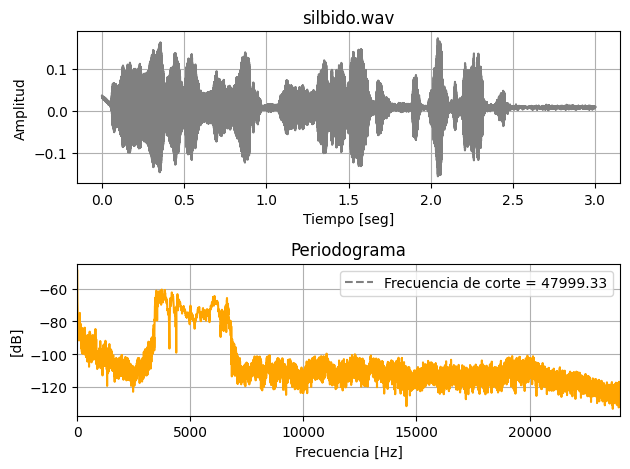

In [22]:
# ------------------------------------------- Audio 2 -> 'silbido.wav' ------------------------------------------- #


# Utilizo método de Blackman-Tukey
per_audio_2 = blackman_tukey (wav_data_2, M = None) / N_2
per_audio_2_dB = 10*np.log10(per_audio_2)

energia_acum_2 = np.cumsum (per_audio_2)
energia_acum_2_norm = energia_acum_2 / energia_acum_2[-1]
corte_2 = energia_acum_2_norm[-1] * 0.995
indice_corte_2 = (int) (np.where (energia_acum_2_norm >= corte_2)[0][0])
frec_corte_2 = ff_2[indice_corte_2]


plt.figure (7)

plt.subplot (2, 1, 1)
plt.plot (tt_2, wav_data_2, color='gray')
plt.title ('silbido.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_2, per_audio_2_dB, color='orange')
plt.axvline (frec_corte_2, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_2:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.xlim (0, fs_2/2)
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

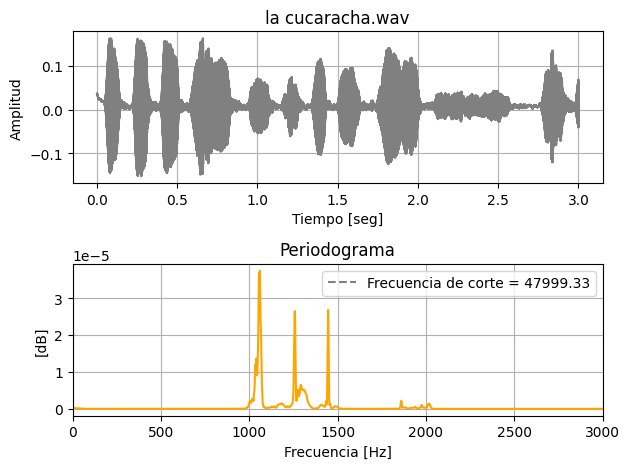

In [23]:
# ------------------------------------------- Audio 3 -> 'la cucaracha.wav' ------------------------------------------- #


# Utilizo método de Welch
promedios_audio_3 = 10 # defino la cantidad de bloques a promediar
nperseg_audio_3 = N_3 // promedios_audio_3
ff_3_welch, per_audio_3 = sp.welch (wav_data_3, nfft = 10*nperseg_audio_3, fs = fs_3, nperseg = nperseg_audio_3, window = 'hann')

energia_acum_3 = np.cumsum (per_audio_3)
energia_acum_3_norm = energia_acum_3 / energia_acum_3[-1]
corte_3 = energia_acum_3_norm[-1] * 0.995
indice_corte_3 = (int) (np.where (energia_acum_3_norm >= corte_3)[0][0])
frec_corte_3 = ff_3[indice_corte_2]


plt.figure (8)

plt.subplot (2, 1, 1)
plt.plot (tt_3, wav_data_3, color='gray')
plt.title ('la cucaracha.wav')
plt.xlabel ('Tiempo [seg]')
plt.ylabel ('Amplitud')
plt.grid (True)

plt.subplot (2, 1, 2)
plt.plot (ff_3_welch, per_audio_3, color='orange')
plt.axvline (frec_corte_3, linestyle='--', color='gray', label=f'Frecuencia de corte = {frec_corte_3:.2f}')
plt.title ('Periodograma')
plt.xlabel ('Frecuencia [Hz]')
plt.ylabel ('[dB]')
plt.xlim (0, 3000)
plt.grid (True)
plt.legend ()

plt.tight_layout()
plt.show()

## Conclusiones



## Autoevaluación del aprendizaje